# Tara Model

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Getting the Data from the folders ###

In [2]:
import os
import numpy as np

In [3]:

PATH='TaraData/'
os.makedirs(PATH,exist_ok=True)

    

In [4]:
import torch
import torchvision
import torchtext

In [6]:
from fastai.conv_learner import *

In [7]:
stats = (np.array([0.64604099, 0.64627529, 0.64668059]), np.array([0.64635304, 0.64659761, 0.64700603]))

In [8]:
augs = [RandomFlip(),
       RandomDihedral(),
       RandomLighting(0.05,0.05)]

def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=augs)
    return ImageClassifierData.from_paths(PATH, trn_name='train_group_prune',val_name='test_group_prune', tfms=tfms, bs=bs)

In [9]:
bs=256

## Look at the data

In [10]:
data = get_data(75,15)

In [11]:
x,y=next(iter(data.trn_dl))



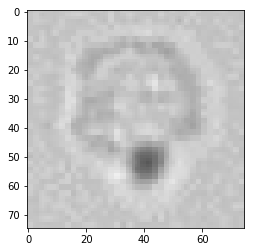

In [12]:
plt.imshow(data.trn_ds.denorm(x)[3])


In [13]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

## Initial Model 

In [14]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True, opt_fn=optim.Adam, ps=0.5)


In [145]:
learn.save('tmp-group-prune2')

 61%|██████    | 9849/16217 [02:10<01:24, 75.48it/s, loss=4.57]

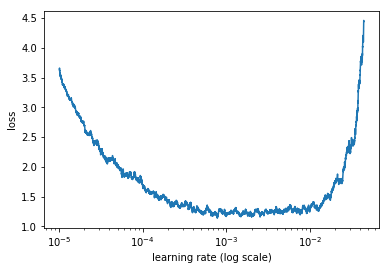

In [146]:
lrf=learn.lr_find()
learn.sched.plot()

In [147]:
learn.fit(0.001, 1, cycle_len=1, cycle_mult=1)

epoch      trn_loss   val_loss   accuracy                        
    0      1.076689   0.921959   0.687581  


[array([0.92196]), 0.6875812476345625]

In [148]:
learn.fit(0.001, 4, cycle_len=1, cycle_mult=2)


epoch      trn_loss   val_loss   accuracy                        
    0      1.043809   0.902969   0.693192  
    1      1.013901   0.897392   0.697635                        
    2      1.041127   0.879313   0.701173                        
    3      1.030468   0.892279   0.69984                         
    4      0.895154   0.87991    0.702555                        
    5      0.989979   0.86116    0.706093                        
    6      0.968437   0.862091   0.707903                        
    7      0.99696    0.878722   0.700104                        
    8      0.990188   0.879974   0.699676                        
    9      0.978148   0.868917   0.704777                        
    10     0.960696   0.859897   0.706998                        
    11     1.042082   0.85854    0.709829                        
    12     0.949364   0.851803   0.709286                        
    13     0.990075   0.848556   0.710043                        
    14     0.959192   0.849222  

[array([0.84922]), 0.7115400437708775]

In [149]:
learn.save('tmp-group-prune2')

In [15]:
learn.load('tmp-group-prune2')

In [17]:
lr=0.001

In [19]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

 30%|██▉       | 4806/16217 [45:56<1:49:04,  1.74it/s, loss=1.01] 

In [153]:
learn.save('tmp-group-prune3')

In [128]:
#qdding L2 regurqlization
wd=5e-4
learn.fit(lrs, 1, cycle_len=1, wds=wd)
 

epoch      trn_loss   val_loss   accuracy                           
    0      1.082127   0.98528    0.68077   


[array([0.98528]), 0.6807700990035152]

In [129]:
multi_preds, y = learn.TTA()


In [131]:
preds = np.mean(multi_preds, 0)
metrics.log_loss(y,preds)

3.367295980453491

In [132]:
preds1 = torch.max(torch.LongTensor(preds), dim=1)[1]
p1=np.array(preds1)

In [133]:
from sklearn.metrics import confusion_matrix
c=confusion_matrix(y, p1)
labels=["artefact","autotroph","Bacillariophyceae","centric","Cerataulina","Chaetoceros","cyst","detritus","Dictyochales","Dinophyceae","Dinophysaceae","Eukaryota","Fragilariopsis","Gonyaulacales","Gymnodiniales","Haptophyta","heterotroph","htm","Nitzschia","other","part","pennate","Prorocentrales","Protoplastes","Prymnesiophyceae","Pseudo-nitzschia","Rhizosolenids","shells","Thoracosphaerales"]

In [134]:
for i in range(29):
    print (labels[i])
    print (c[i][i]/sum(c[i]))

artefact
0.47586206896551725
autotroph
0.0
Bacillariophyceae
0.0
centric
0.45811051693404636
Cerataulina
0.0
Chaetoceros
0.0
cyst
0.0
detritus
0.41379310344827586
Dictyochales
0.7821698906644239
Dinophyceae
0.0
Dinophysaceae
0.2625
Eukaryota
0.03980099502487562
Fragilariopsis
0.21846153846153846
Gonyaulacales
0.02127659574468085
Gymnodiniales
0.3329326923076923
Haptophyta
0.7234617985125085
heterotroph
0.0
htm
0.0
Nitzschia
0.21096345514950166
other
0.5177935943060499
part
0.5132686084142395
pennate
0.66073546856465
Prorocentrales
0.8059483797323863
Protoplastes
0.02745995423340961
Prymnesiophyceae
0.9013434658705387
Pseudo-nitzschia
0.562369337979094
Rhizosolenids
0.8284596266723071
shells
0.18278615794143743
Thoracosphaerales
0.1894463667820069
